# Задание 2. Тестирование стратегии статистического арбитража

In [ ]:
# Цель задания:
### 1. Получить первичные навыки построения и тестирования стратегий
### 2. Получить представление об основных инструментах языка Python (классы, функции)
### 3. Реализовать стратегию статистического арбитража 

### Рекомендуемая литература:
### 1.Y.Hilpish "Python for Finance"
### 2.J.M. Weiming "Mastering Python for Finance"
### 3.W. McKinney "Python for Data Analysis"

In [ ]:
## 1. Загрузка библиотек

In [18]:
import numpy as np
import pandas as pd

In [19]:
from scipy import stats # статистическая библиотека  

In [20]:
from sklearn.linear_model import LinearRegression # регрессионный анализ  

In [21]:
from __future__ import division

In [22]:
import matplotlib.pyplot as plt # графическая библиотека
%matplotlib inline 

In [23]:
from datetime import datetime,timedelta # работа с форматом даты

In [24]:
import statsmodels.tsa.stattools as st ### анализ временных рядов

## 2. Загрузка данных

### В качестве примера будем использовать данные по фьючерсам на нефть WTI. Для анализа возьмем два ближайших фьючерса.

In [25]:
path='/home/maxime/Documentos/Derivatives/LIBOR/'

In [26]:
Oil_fut=pd.read_excel(path+'PET_PRI_FUT_S1_D.xls',sheet_name='Data 1',header=None,skiprows=3,
                      usecols=[0,1,2,3,4],names=['Date','Fut_1','Fut_2','Fut_3','Fut_4'])

In [27]:
Oil_fut.head()

,Date,Fut_1,Fut_2,Fut_3,Fut_4
0,1983-03-30,NaN,NaN,29.35,NaN
1,1983-03-31,NaN,NaN,29.24,NaN
2,1983-04-04,29.44,NaN,29.10,NaN
3,1983-04-05,29.71,NaN,29.35,NaN
4,1983-04-06,29.92,NaN,29.50,NaN


In [28]:
Oil_fut.dtypes

Date     datetime64[ns]
Fut_1           float64
Fut_2           float64
Fut_3           float64
Fut_4           float64
dtype: object

In [29]:
Oil_fut=Oil_fut[(Oil_fut.Date>'2010-01-01')&(Oil_fut.Date<'2016-01-01')]

In [30]:
Oil_fut.dropna(inplace=True)

In [31]:
Oil_fut.tail()

,Date,Fut_1,Fut_2,Fut_3,Fut_4
8217,2015-12-24,38.10,39.11,39.93,40.64
8218,2015-12-28,36.81,37.82,38.66,39.40
8219,2015-12-29,37.87,38.86,39.69,40.40
8220,2015-12-30,36.60,37.64,38.51,39.27
8221,2015-12-31,37.04,38.17,39.13,39.98


In [32]:
Oil_fut.shape

(1510, 5)

## 3. Проверка на стационарность

In [33]:
X=(np.array(np.log(Oil_fut.Fut_1))).reshape(-1,1)

In [34]:
X.shape

(1510, 1)

In [35]:
Y=(np.array(np.log(Oil_fut.Fut_2))).reshape(-1,1)

In [36]:
reg=LinearRegression(fit_intercept=False).fit(X,Y)

In [37]:
(reg.coef_[0][0])

1.0012695920885895

In [38]:
Y_hat=reg.predict(X)

In [39]:
Y_resid=Y-Y_hat

In [40]:
Y_resid.ravel().shape

(1510,)

In [41]:
np.mean(Y_resid),np.std(Y_resid)

(0.00043602977099023259, 0.010941703319949935)

In [42]:
st.adfuller(Y_resid.ravel())[1]

0.013992128864109324

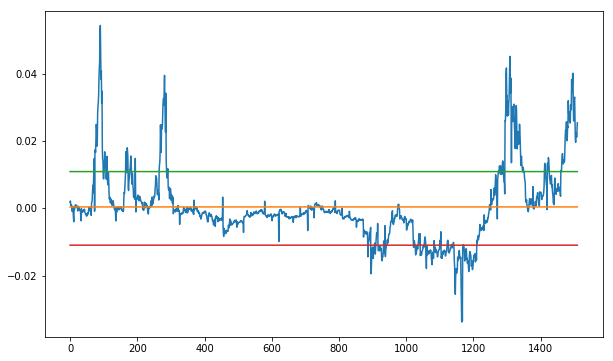

In [43]:
k=1
plt.figure(figsize=(10,6))
_=plt.plot(Y_resid)
_=plt.plot(np.repeat(np.mean(Y_resid),len(Y_resid)))
_=plt.plot(np.repeat(np.std(Y_resid)*k,len(Y_resid)))
_=plt.plot(np.repeat(np.std(Y_resid)*-k,len(Y_resid)))

## 4. Полезные функции

In [44]:
# расчет остатков уравнения регрессии
def reg_resid_func(Instr_1,Instr_2):
    Y=np.log(Instr_1)
    X=np.log(Instr_2)
    reg=LinearRegression(fit_intercept=False)
    reg.fit(X,Y)
    Y_pred=reg.predict(X)
    return((Y-Y_pred),reg.coef_[0][0])

In [45]:
# проверка на стационарность
def stationarity_check_func(data_spread,alpha=0.05):
    stationarity=False
    if st.adfuller(data_spread.ravel())[1]<alpha:
        stationarity=True
    return stationarity   

In [46]:
# расчет параметров рапсределения спрэда
def param_func(data_spread):
    return (np.mean(data_spread),np.std(data_spread))

In [47]:
# получение сингала
def signal_func_open(spread,mean,sigma,k):
    signal='No'
    if spread<=mean-sigma*k:
        signal='Buy'
    elif spread>=mean+sigma*k:
        signal='Sell'
    return signal    

In [48]:
# преобазование значений цен в число с плавающей точкой
def get_prices(instr1,instr2):
    return (float(instr1),float(instr2))

## 5. Создание класса для описания позиции

### long:  first -buy, second-sell
### short: first - sell, second-buy

In [49]:
class Position(object):
    
    def __init__(self):
        self._initial_position=(None,None,0,0,0)
        #date_initial,direction,price_1,price_2,beta,comission
        self._close_position=(None,None,0,0,0)
        #date_close,signal,price_1,price_2,comission

    @property # вывод данных по открытию позиции
    def initial_position(self):
        return self._initial_position
    
    @initial_position.setter # ввод данных для открытия позиции
    def initial_position(self, initial_position):
        self._initial_position=initial_position
        

    @property # # вывод данных по закрытию позиции
    def close_position(self):
        return self._close_position
        
    
    @close_position.setter # ввод данных для закрытия позиции
    def close_position(self, close_position):
        self._close_position=close_position
        
        
    def get_result(self): # расчет результата
        Date_setup,Direction,Instr_1_Price_initial,Instr_2_Price_initial,Beta,Comission_init=self._initial_position
        Date_close,Close_type,Instr_1_Price_close,Instr_2_Price_close,Comission_close=self._close_position
        if ((Date_setup==None)|(Date_close==None)):
            return 0
        else:
            return ((np.log(Instr_1_Price_close)-np.log(Instr_1_Price_initial))\
                -(np.log(Instr_2_Price_close)-np.log(Instr_2_Price_initial))*Beta-Comission_init) if Direction=='Long'\
    else (-(np.log(Instr_1_Price_close)-np.log(Instr_1_Price_initial))\
          +(np.log(Instr_2_Price_close)-np.log(Instr_2_Price_initial))*Beta-Comission_close)

In [50]:
pos=Position()

In [51]:
initial_position=('2019-04-02','Short',5,6,1.1,0)

In [52]:
pos.initial_position=initial_position

In [53]:
pos.initial_position

('2019-04-02', 'Short', 5, 6, 1.1, 0)

In [54]:
pos.close_position=('2019-04-02','Signal',5,8,0)

In [55]:
pos.close_position

('2019-04-02', 'Signal', 5, 8, 0)

In [38]:
pos.get_result()

0.31645027969695888

## 6. Реализация стратегии

In [56]:
n=Oil_fut.shape[0]
n

1510

In [57]:
# преобразование первоначального массива цен в формат, необходимый для уравнения регрессии
Instr_1=(np.array((Oil_fut.iloc[0:,1]))).reshape(-1,1)
Instr_2=(np.array((Oil_fut.iloc[0:,2]))).reshape(-1,1)
Date=list((Oil_fut.iloc[0:,0]))

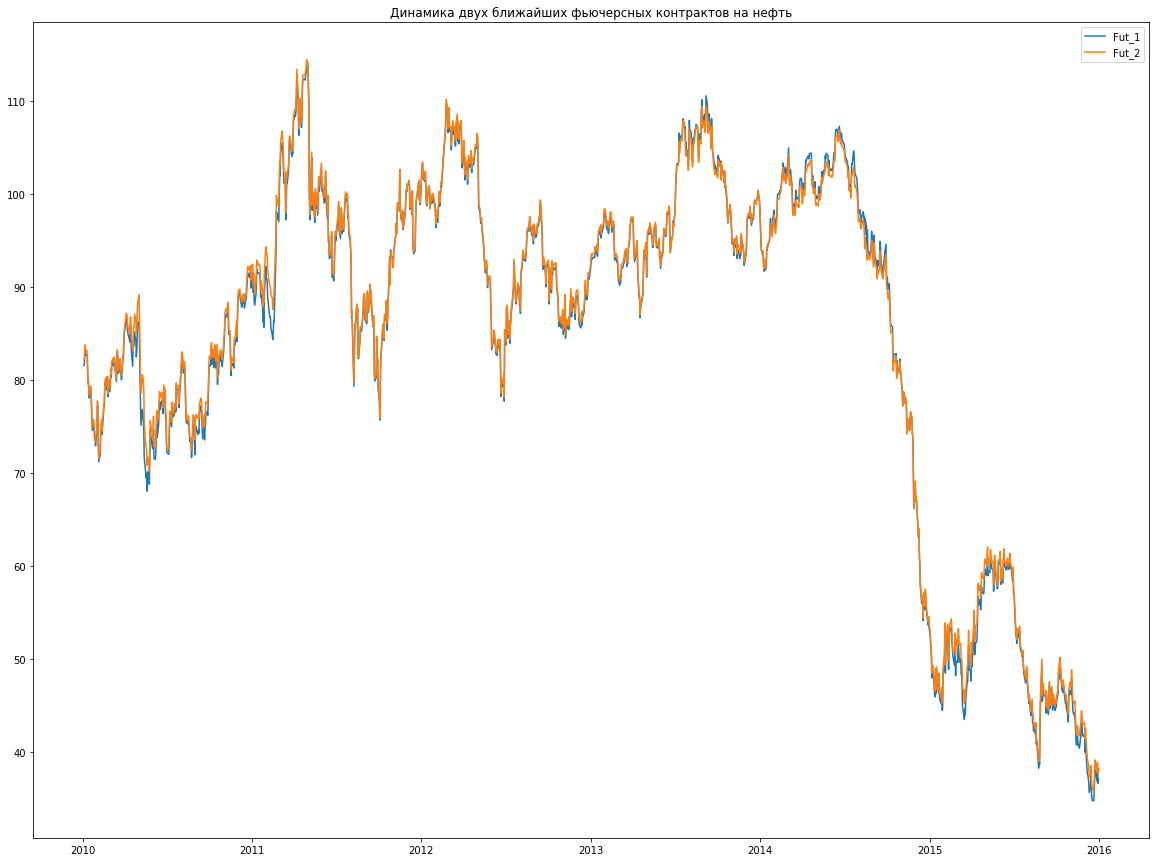

In [58]:
_=plt.figure(figsize=(20,15))
_=plt.plot(Date,Instr_1,label='Fut_1')
_=plt.plot(Date,Instr_2,label='Fut_2')
_=plt.title(u'Динамика двух ближайших фьючерсных контрактов на нефть')
__=plt.legend()

In [60]:
# инициализация параметров стратегии
days_stationarity_check_max=20 # частота проверки на стационарность
days_position_max=3 # количество дней, которые мы держим позицию
window=250 # количество данных, используемых для проверки стационарности
k=0.5 # mu +/- k*sigma
comission=0 # размер комиссиии
stop_profit=0.001

In [61]:
# инициализация переменных 
result=[] # массив для фиксации результатов
stationarity_check=False
pos_days=0
i=window
stationatity_check_index=window 

In [62]:
while ((i)<n):
    #print(i)
    if (pos_days==0):
        if (((i-stationatity_check_index)>days_stationarity_check_max)|(i==window)):
            resid,beta=reg_resid_func(Instr_1[(i-window):i],Instr_2[(i-window):i])
            stationarity=stationarity_check_func(resid) # проверка на стационарность 
            if stationarity:
                mean,sigma=param_func(resid)
            stationatity_check_index=i
        if stationarity: # если ряд стационарен, проверяем наличие сигнала
            price_1,price_2=get_prices(Instr_1[i],Instr_2[i])
            spread=float(np.log(price_1)-np.log(price_2)*beta)
            signal=signal_func_open(spread,mean,sigma,k)
            #print(spread,mean,sigma,(mean+sigma*k))
            #print(signal)
            if (signal<>'No'):  # если есть сигнал, занимаем позицию            
                pos_direction='Long' if signal=='Buy' else 'Short' 
                pos=Position() 
                pos.initial_position=(Date[i],pos_direction,price_1,price_2,beta,comission)
                pos_days=1
                i+=1
            else: i+=1   
        else: i+=1      
    else:
        price_1,price_2=get_prices(Instr_1[i],Instr_2[i])
        if (pos_days<days_position_max):# если время позиции не превысило лимит, проверяем результат
            pos.close_position=(Date[i],'Signal',price_1,price_2,comission)
            res=pos.get_result()
            if (res>stop_profit):# если результат положительный, закрываем позицию
                result.append(list(pos.initial_position)+list(pos.close_position)+[round(pos.get_result(),4)])
                pos_days=0
            else:
                pos_days+=1
                i+=1
        else:
            pos.close_position=(Date[i],'Time',price_1,price_2,comission)
            # если время позиции превысило лимит, закрываем позицию
            result.append(list(pos.initial_position)+list(pos.close_position)+[round(pos.get_result(),4)])
            pos_days=0
            #print('Time_close')

In [63]:
df=pd.DataFrame(result,columns=['Date_open','Direction','Price_1_init','Price_2_init','Beta','Comission_init',\
                        'Date_close','Type','Price_1_close','Price_2_close','Comission_close','Result'])
# массив с результатами реализации стратегии

In [64]:
df

,Date_open,Direction,Price_1_init,Price_2_init,Beta,Comission_init,Date_close,Type,Price_1_close,Price_2_close,Comission_close,Result
0,2011-03-08,Short,105.02,105.95,0.996848,0,2011-03-09,Signal,104.38,105.61,0,0.0029
1,2011-03-15,Short,97.18,97.98,0.996848,0,2011-03-16,Signal,97.98,98.95,0,0.0016
2,2011-03-18,Short,101.07,101.85,0.996848,0,2011-03-22,Signal,104.00,104.97,0,0.0015
3,2011-03-23,Short,105.75,106.21,0.996848,0,2011-03-28,Time,103.98,104.56,0,0.0013
4,2011-03-28,Short,103.98,104.56,0.996848,0,2011-03-31,Time,106.72,107.24,0,-0.0008
5,2011-03-31,Short,106.72,107.24,0.996789,0,2011-04-05,Time,108.34,108.99,0,0.0011
6,2011-04-05,Short,108.34,108.99,0.996789,0,2011-04-08,Time,112.79,113.37,0,-0.0010
7,2011-04-08,Short,112.79,113.37,0.996789,0,2011-04-12,Signal,106.25,106.97,0,0.0018
8,2011-04-12,Short,106.25,106.97,0.996789,0,2011-04-15,Time,109.66,110.22,0,-0.0018
9,2011-04-15,Short,109.66,110.22,0.996789,0,2011-04-20,Time,111.45,111.91,0,-0.0010


In [65]:
sum(df.Result*1000000) # результат стратегии для 1 млн. USD - 50 пар

9700.0

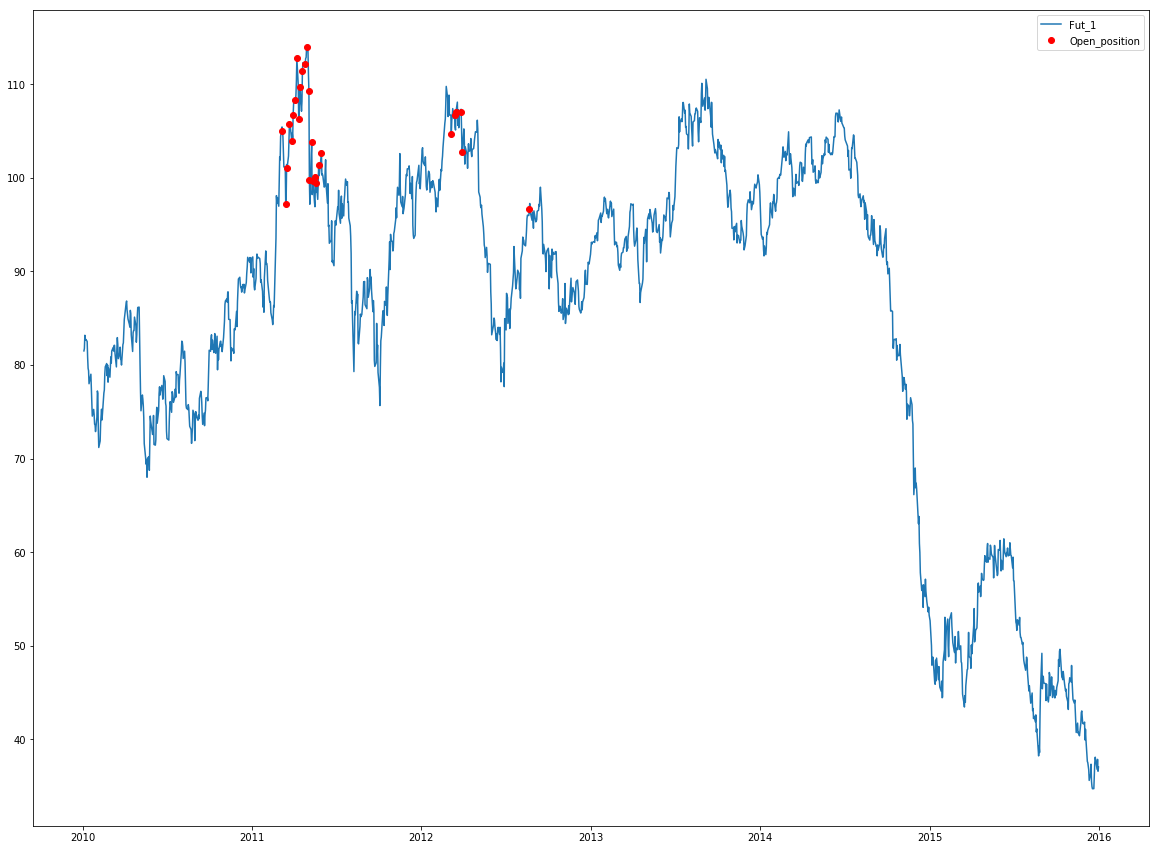

In [66]:
_=plt.figure(figsize=(20,15))
_=plt.plot(Date,Instr_1,label='Fut_1')
#_=plt.plot(Date,Instr_2,label='Fut_2')
plt.plot(df.Date_open,df.Price_1_init,'bo',color='red',label='Open_position')
__=plt.legend()

In [ ]:
## Задание

In [ ]:
### 1. Выбрать два актива, зависящих от сходных экономических факторов (или факторов риска).
### 2. Протестировать стратегию статистического арбитража по аналогии с разобранным примером.
### 3. Сделать выводы